In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Set parameters
IMG_SIZE = 224  # MobileNetV2 input size
BATCH_SIZE = 32
EPOCHS = 12
BASE_DIR = r"C:\Users\HP\OneDrive\Desktop\AI Plants\Backend\Data\PlantVillage"

In [3]:
# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Get class names
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Number of classes: 15
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [4]:
# Create the base model from MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Create callbacks to improve training
checkpoint = ModelCheckpoint(
    'plant_disease_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]

In [6]:
import math

# Calculate steps per epoch using ceiling division to cover all samples
steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(validation_generator.samples / BATCH_SIZE)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)


C:\Users\HP\OneDrive\Desktop\AI Plants\Backend\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5330 - loss: 1.4670
Epoch 1: val_accuracy improved from -inf to 0.83115, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 983s 2s/step - accuracy: 0.5332 - loss: 1.4663 - val_accuracy: 0.8311 - val_loss: 0.5296 - learning_rate: 0.0010
Epoch 2/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7601 - loss: 0.7161
Epoch 2: val_accuracy improved from 0.83115 to 0.85129, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 922s 2s/step - accuracy: 0.7601 - loss: 0.7161 - val_accuracy: 0.8513 - val_loss: 0.4385 - learning_rate: 0.0010
Epoch 3/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7839 - loss: 0.6448
Epoch 3: val_accuracy improved from 0.85129 to 0.86827, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 906s 2s/step - accuracy: 0.7839 - loss: 0.6448 - val_accuracy: 0.8683 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 4/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8105 - loss: 0.5712
Epoch 4: val_accuracy improved from 0.86827 to 0.87482, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.8105 - loss: 0.5712 - val_accuracy: 0.8748 - val_loss: 0.3788 - learning_rate: 0.0010
Epoch 5/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8165 - loss: 0.5470
Epoch 5: val_accuracy did not improve from 0.87482
517/517 ━━━━━━━━━━━━━━━━━━━━ 686s 1s/step - accuracy: 0.8165 - loss: 0.5470 - val_accuracy: 0.8748 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 6/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8244 - loss: 0.5188
Epoch 6: val_accuracy improved from 0.87482 to 0.87991, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.8244 - loss: 0.5188 - val_accuracy: 0.8799 - val_loss: 0.3532 - learning_rate: 0.0010
Epoch 7/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8328 - loss: 0.4988
Epoch 7: val_accuracy improved from 0.87991 to 0.89180, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 764s 1s/step - accuracy: 0.8328 - loss: 0.4988 - val_accuracy: 0.8918 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 8/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8375 - loss: 0.4853
Epoch 8: val_accuracy did not improve from 0.89180
517/517 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.8375 - loss: 0.4853 - val_accuracy: 0.8901 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 9/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8317 - loss: 0.4976
Epoch 9: val_accuracy did not improve from 0.89180
517/517 ━━━━━━━━━━━━━━━━━━━━ 770s 1s/step - accuracy: 0.8318 - loss: 0.4976 - val_accuracy: 0.8913 - val_loss: 0.3239 - learning_rate: 0.0010
Epoch 10/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8414 - loss: 0.4675
Epoch 10: val_accuracy improved from 0.89180 to 0.89471, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 881s 2s/step - accuracy: 0.8414 - loss: 0.4675 - val_accuracy: 0.8947 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 11/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8418 - loss: 0.4745
Epoch 11: val_accuracy did not improve from 0.89471
517/517 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.8418 - loss: 0.4745 - val_accuracy: 0.8942 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 12/12
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8496 - loss: 0.4535
Epoch 12: val_accuracy improved from 0.89471 to 0.89908, saving model to plant_disease_model.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 892s 2s/step - accuracy: 0.8496 - loss: 0.4535 - val_accuracy: 0.8991 - val_loss: 0.2996 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 12.


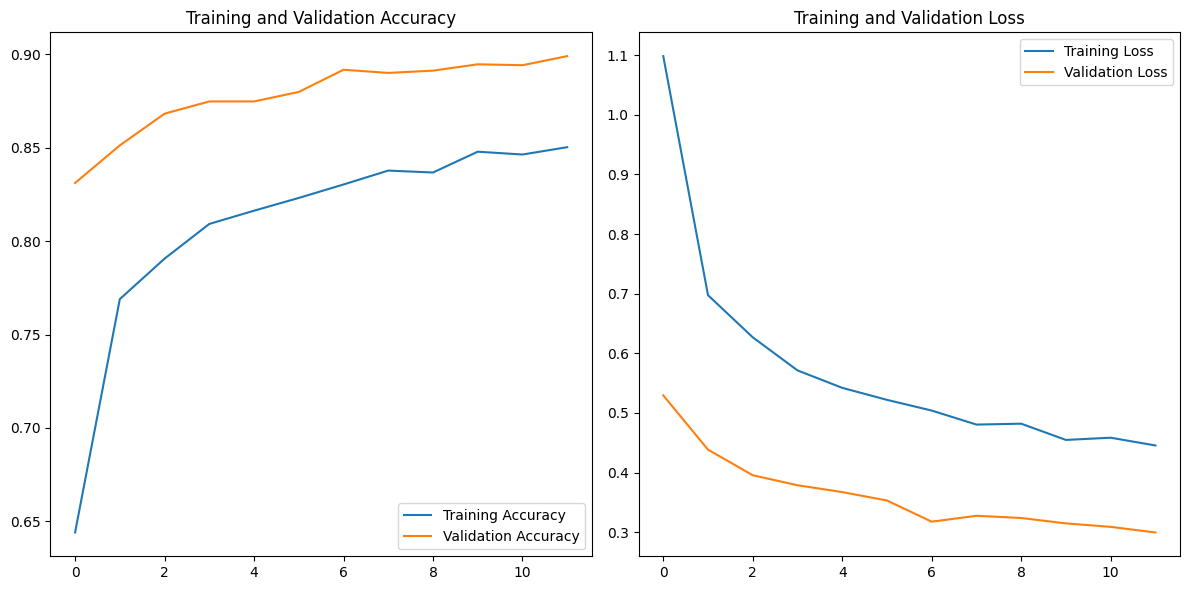

In [7]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [8]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create a NEW checkpoint just for fine-tuning
fine_tune_checkpoint = ModelCheckpoint(
    'plant_disease_model_finetuned.h5',  # Different filename
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Use the same early stopping and reduce LR, but with the new checkpoint
fine_tune_callbacks = [fine_tune_checkpoint, early_stop, reduce_lr]

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # A few more epochs for fine-tuning
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=fine_tune_callbacks,  # Use new callbacks
    verbose=1
)


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7671 - loss: 0.8019
Epoch 1: val_accuracy improved from -inf to 0.75619, saving model to plant_disease_model_finetuned.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 1101s 2s/step - accuracy: 0.7672 - loss: 0.8015 - val_accuracy: 0.7562 - val_loss: 1.0323 - learning_rate: 1.0000e-04
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8735 - loss: 0.3758
Epoch 2: val_accuracy improved from 0.75619 to 0.89180, saving model to plant_disease_model_finetuned.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 885s 2s/step - accuracy: 0.8736 - loss: 0.3758 - val_accuracy: 0.8918 - val_loss: 0.3251 - learning_rate: 1.0000e-04
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9054 - loss: 0.2913
Epoch 3: val_accuracy improved from 0.89180 to 0.92237, saving model to plant_disease_model_finetuned.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 893s 2s/step - accuracy: 0.9054 - loss: 0.2913 - val_accuracy: 0.9224 - val_loss: 0.2410 - learning_rate: 1.0000e-04
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9219 - loss: 0.2450
Epoch 4: val_accuracy improved from 0.92237 to 0.94081, saving model to plant_disease_model_finetuned.h5


517/517 ━━━━━━━━━━━━━━━━━━━━ 795s 2s/step - accuracy: 0.9219 - loss: 0.2450 - val_accuracy: 0.9408 - val_loss: 0.1787 - learning_rate: 1.0000e-04
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9330 - loss: 0.2107
Epoch 5: val_accuracy did not improve from 0.94081
517/517 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.9330 - loss: 0.2107 - val_accuracy: 0.9284 - val_loss: 0.2405 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 4.


In [9]:
# Save the model
model.save('plant_disease_final_model.h5')
print("Model saved successfully!")

# Save class names for inference
import json
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved successfully!")

Model saved successfully!
Class names saved successfully!


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_disease(image_path):
    """
    Predict plant disease from an image file
    
    Args:
        image_path: Path to the image file
        
    Returns:
        Class name and confidence score
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Get the predicted class and confidence
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index]
    predicted_class = class_names[predicted_class_index]
    
    # Display the results
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


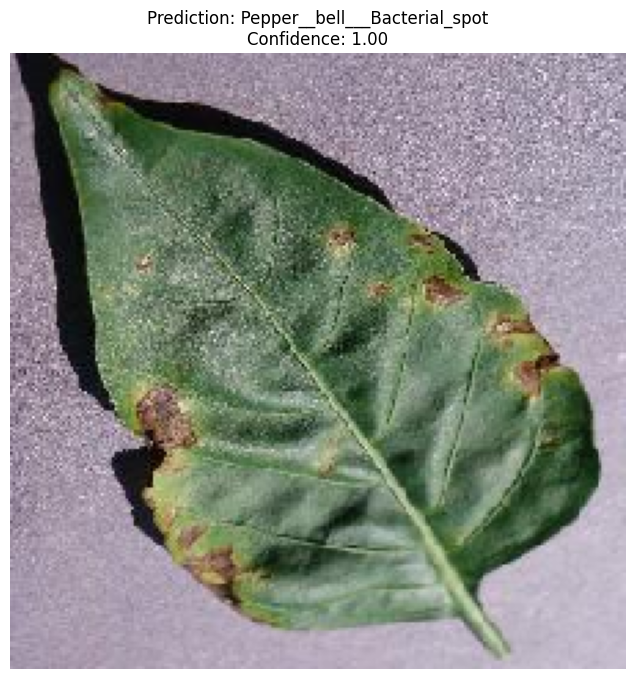

Predicted disease: Pepper__bell___Bacterial_spot
Confidence: 1.00


In [13]:
# Test with a sample image - update the path to your test image
sample_image_path = r"C:\Users\HP\OneDrive\Desktop\AI Plants\Backend\Data\PlantVillage\Pepper__bell___Bacterial_spot\00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG"
predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted disease: {predicted_class}")
print(f"Confidence: {confidence:.2f}")